In [9]:
import collections
import itertools
import time

from graph_nets import graphs
from graph_nets import utils_np
from graph_nets import utils_tf
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import spatial
import tensorflow as tf

from graph_utils.generate_graph import generate_graph
import models
SEED = 1
np.random.seed(SEED)
tf.set_random_seed(SEED)

In [5]:
grph = generate_graph(num_nodes_min_max=[30, 35])

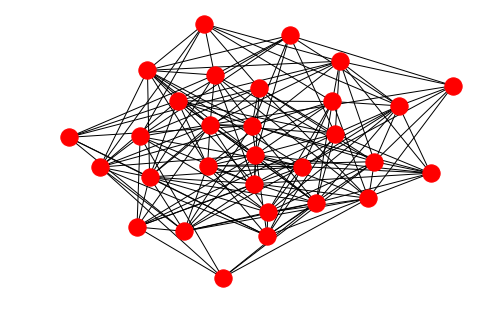

In [7]:
nx.draw(grph)

In [10]:
model = models.EncodeProcessDecode(edge_output_size=2, node_output_size=2)


In [12]:
def graph_to_input_target(graph):
    """Returns 2 graphs with input and target feature vectors for training.

    Args:
        graph: An `nx.DiGraph` instance.

    Returns:
        The input `nx.DiGraph` instance.
        The target `nx.DiGraph` instance.

    Raises:
        ValueError: unknown node type
    """

    def create_feature(attr, fields):
        return np.hstack([np.array(attr[field], dtype=float) for field in fields])

    input_node_fields = ("pos", "weight", "start", "end")
    input_edge_fields = ("distance",)
    target_node_fields = ("solution",)
    target_edge_fields = ("solution",)

    input_graph = graph.copy()
    target_graph = graph.copy()

    solution_length = 0
    for node_index, node_feature in graph.nodes(data=True):
        input_graph.add_node(
            node_index, features=create_feature(node_feature, input_node_fields))
        target_node = to_one_hot(
            create_feature(node_feature, target_node_fields).astype(int), 2)[0]
        target_graph.add_node(node_index, features=target_node)
        solution_length += int(node_feature["solution"])
    
    solution_length /= graph.number_of_nodes()

    for receiver, sender, features in graph.edges(data=True):
        input_graph.add_edge(
            sender, receiver, features=create_feature(features, input_edge_fields))
        target_edge = to_one_hot(
            create_feature(features, target_edge_fields).astype(int), 2)[0]
        target_graph.add_edge(sender, receiver, features=target_edge)

    input_graph.graph["features"] = np.array([0.0])
    target_graph.graph["features"] = np.array([solution_length], dtype=float)

    return input_graph, target_graph

In [ ]:
def create_placeholders(rand, batch_size, num_nodes_min_max, theta):
    """Creates placeholders for the model training and evaluation.

    Args:
        rand: A random seed (np.RandomState instance).
        batch_size: Total number of graphs per batch.
        num_nodes_min_max: A 2-tuple with the [lower, upper) number of nodes per
          graph. The number of nodes for a graph is uniformly sampled within this
          range.
        theta: A `float` threshold parameters for the geographic threshold graph's
          threshold. Default= the number of nodes.

    Returns:
        input_ph: The input graph's placeholders, as a graph namedtuple.
        target_ph: The target graph's placeholders, as a graph namedtuple.
    """
    # Create some example data for inspecting the vector sizes.
    input_graphs, target_graphs, _ = generate_networkx_graphs(
        rand, batch_size, num_nodes_min_max, theta)
    input_ph = utils_tf.placeholders_from_networkxs(
        input_graphs, force_dynamic_num_graphs=True)
    target_ph = utils_tf.placeholders_from_networkxs(
        target_graphs, force_dynamic_num_graphs=True)
    return input_ph, target_ph
